In [1]:
from math import exp
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib notebook
from tqdm import tqdm
import numpy as np

## Settings

In [2]:
C = 0.9
R = 3

## Code

In [3]:
# parameters
r_min = 0
r_max = 1.8
c = 1.5
a = 0.6
b = 1.2
T = 3
t = 0
count1 = 100
count2 = 300
count3 = 900
h1 = (r_max - r_min) / count1
h2 = (r_max - r_min) / count2
h3 = (r_max - r_min) / count3
tau1 = C * h1 / c
tau2 = C * h2 / c
tau3 = C * h3 / c

In [4]:
def r(i, h):
    return r_min + (i - 0.5)*h
r1 = [r(i, h1) for i in range(count1 + 2)]
r2 = [r(i, h2) for i in range(count2 + 2)]
r3 = [r(i, h3) for i in range(count3 + 2)]

In [5]:
def get_v0(r):
    if a < r < b:
        return exp((-4*(2*r - (a + b))**2) / ((b - a)**2 - (2*r - (a + b))**2))
    return 0

In [6]:
def gen_next(u, f, u_prev, h, tau, r):
    u_next = [0 for _ in range(len(u))]
    for i in range(1, len(u) - 1):
        u_next[i] = 2 * u[i] - u_prev[i] + (tau**2 * c**2) / (r[i]**(R-1) * h) * (
            (((r[i + 1] + r[i])/2)**(R-1) * (u[i+1] - u[i]) / h) - (
                ((r[i] + r[i - 1])/2)**(R-1) * (u[i] - u[i-1]) / h)) + tau**2 * f[i]
    u_next[0] = u_next[1]
    u_next[-1] = u_next[-2]
    return u_next

In [7]:
def calc_C(u1, u2):
    if len(u1) == count1 + 2:
        u1_ = u1[1:-1]
        u2_ = u2[2:-2:3]
        ans = [abs(u1_[i] - u2_[i]) for i in range(len(u2_))]
#         print('грубая', min(ans))
    else:
        u1_ = u1[2:-2:3]
        u2_ = u2[5:-5:9]
        ans = [abs(u1_[i] - u2_[i]) for i in range(len(u2_))]
#         print('мелкая', min(ans))
    return max(ans)

In [8]:
def calc_L2(u1, u2):
    if len(u1) == count1 + 2:
        u1_ = u1[1:-1]
        u2_ = u2[2:-2:3]
    else:
        u1_ = u1[2:-2:3]
        u2_ = u2[5:-5:9]
    ans = [(abs(u1_[i] - u2_[i]))**2 for i in range(len(u2_))]
    return sqrt(sum(ans))

In [9]:
u01 = [get_v0(r(i, h1)) for i in range(count1 + 2)]
u02 = [get_v0(r(i, h2)) for i in range(count2 + 2)]
u03 = [get_v0(r(i, h3)) for i in range(count3 + 2)]
f1 = [0 for _ in range(count1 + 2)]
f2 = [0 for _ in range(count2 + 2)]
f3 = [0 for _ in range(count3 + 2)]

In [10]:
from sympy import *

rs = symbols('r')
f_ = lambda t, r: 0
v0s = exp(-4 * (2*rs - (a+b))**2 / ((b-a)**2 - (2*rs - (a+b))**2) )
dudt2s = c**2 * (1/rs**(R-1)) * (rs**(R-1) * v0s.diff(rs)).diff(rs) - f_(0, rs)

u1_ = lambda r, tau: get_v0(r) + (tau**2 / 2) * dudt2s.subs(rs, r) if a < r < b else 0

In [11]:
u_next1 = [u1_(r(i, h1), tau1) for i in range(count1 + 2)]

u_next2 = [u1_(r(i, h2), tau2) for i in range(count2 + 2)]
for _ in range(2):
    y2 = gen_next(u_next2, f2, u02, h2, tau2, r2)
    u_next2, u02 = y2, u_next2

u_next3 = [u1_(r(i, h3), tau3) for i in range(count3 + 2)]
for _ in range(8):
    y3 = gen_next(u_next3, f3, u03, h3, tau3, r3)
    u_next3, u03 = y3, u_next3

In [12]:
norm_c = []
norm_L2 = []
time = []
t = 0
with tqdm(total=int(T/tau1)) as pbar:
    while t < T:
        t += tau1
        y1 = gen_next(u_next1, f1, u01, h1, tau1, r1)
        u_next1, u01 = y1, u_next1
        for _ in range(3):
            y2 = gen_next(u_next2, f2, u02, h2, tau2, r2)
            u_next2, u02 = y2, u_next2
        for _ in range(9):
            y3 = gen_next(u_next3, f3, u03, h3, tau3, r3)
            u_next3, u03 = y3, u_next3
        time.append(t)
        norm_L2.append(calc_L2(u_next1, u_next2) / calc_L2(u_next2, u_next3))
        norm_c.append(calc_C(u_next1, u_next2) / calc_C(u_next2, u_next3))
        pbar.update(1)


278it [33:11,  7.16s/it]                                                                                               


<IPython.core.display.Javascript object>


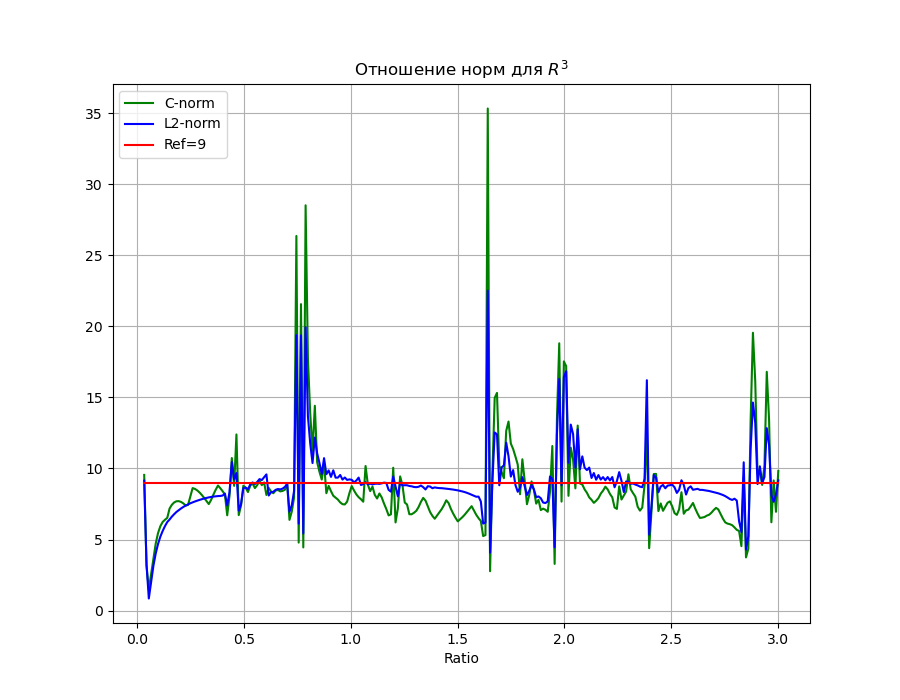

In [14]:
fig, ax = plt.subplots(figsize = (9, 7))
ax.plot(time[2:], norm_c[2:], 'g')
ax.plot(time[2:], norm_L2[2:], 'b')
ax.plot(time[2:], [9 for _ in range(len(time) - 2)], 'r')
ax.set_title("Отношение норм для $R^3$")
ax.grid()
ax.legend(['C-norm', 'L2-norm', 'Ref=9'], loc=2)
ax.set_xlabel('Time')
ax.set_xlabel('Ratio')

plt.show()